In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 32
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "Cifar_10_bagging"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [36]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def CIFARmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [42]:
models = []
accuracies = [0]
patience = 0

for i in count(1):

    print(f"Train model {i}")
    idx = np.random.choice(len(x_train), size=len(x_train), replace=True)

    x_train_model = x_train[idx]
    y_train_model = y_train[idx]

    model = CIFARmodel(IMAGE_SIZE, NUM_CLASSES, 3)
    
    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit(x_train_model,y_train_model,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_val,y_val),
              shuffle = True,
              callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    if delta >= MODEL_ADDITION_DELTA:
      patience = 0
    else:
      patience += 1

    print(f"Model: {i} added. Resulting score: {acc}, Delta: {delta}, Patience: {patience}")

    if patience >= MODEL_ADDITION_PATIENCE:
      break

Train model 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 110us/step - loss: 1.6794 - accuracy: 0.4091 - val_loss: 2.2430 - val_accuracy: 0.1228
Epoch 2/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.2780 - accuracy: 0.5597 - val_loss: 1.4478 - val_accuracy: 0.5140
Epoch 3/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.0833 - accuracy: 0.6325 - val_loss: 1.2243 - val_accuracy: 0.5635
Epoch 4/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.9392 - accuracy: 0.6844 - val_loss: 1.1228 - val_accuracy: 0.6026
Epoch 5/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.8189 - accuracy: 0.7311 - val_loss: 1.1547 - val_accuracy: 0.5985
Epoch 6/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.7168 - accuracy: 0.7698 - val_loss: 1.1023 - val_accuracy: 0.6148
Epoch 7/9999
40000/40000 [===============

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Model: 1 added. Resulting score: 0.6289, Delta: 0.6289, Patience: 0
Train model 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 108us/step - loss: 1.6764 - accuracy: 0.4069 - val_loss: 2.2226 - val_accuracy: 0.1317
Epoch 2/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.2742 - accuracy: 0.5553 - val_loss: 1.5922 - val_accuracy: 0.4274
Epoch 3/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.0779 - accuracy: 0.6313 - val_loss: 1.1884 - val_accuracy: 0.5796
Epoch 4/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.9423 - accuracy: 0.6838 - val_loss: 1.1633 - val_accuracy: 0.5859
Epoch 5/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.8292 - accuracy: 0.7271 - val_loss: 1.2121 - val_accuracy: 0.5744
Epoch 6/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.7245 - accuracy: 0.7679 - val_loss: 1.0

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Model: 2 added. Resulting score: 0.6119, Delta: -0.017000000000000015, Patience: 1
Train model 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 110us/step - loss: 1.6754 - accuracy: 0.4070 - val_loss: 2.3911 - val_accuracy: 0.1266
Epoch 2/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.2694 - accuracy: 0.5584 - val_loss: 1.4179 - val_accuracy: 0.5170
Epoch 3/9999
40000/40000 [==============================] - 4s 96us/step - loss: 1.0718 - accuracy: 0.6319 - val_loss: 1.2435 - val_accuracy: 0.5614
Epoch 4/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.9268 - accuracy: 0.6884 - val_loss: 1.1759 - val_accuracy: 0.5839
Epoch 5/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.8108 - accuracy: 0.7343 - val_loss: 1.1500 - val_accuracy: 0.5916
Epoch 6/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.7053 - accuracy: 0.7739 

100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Model: 3 added. Resulting score: 0.66, Delta: 0.04810000000000003, Patience: 0
Train model 4
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 109us/step - loss: 1.7099 - accuracy: 0.3936 - val_loss: 2.1561 - val_accuracy: 0.1646
Epoch 2/9999
40000/40000 [==============================] - 4s 96us/step - loss: 1.3033 - accuracy: 0.5432 - val_loss: 1.4257 - val_accuracy: 0.4906
Epoch 3/9999
40000/40000 [==============================] - 4s 96us/step - loss: 1.1074 - accuracy: 0.6224 - val_loss: 1.3692 - val_accuracy: 0.5078
Epoch 4/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.9620 - accuracy: 0.6779 - val_loss: 1.2451 - val_accuracy: 0.5663
Epoch 5/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.8407 - accuracy: 0.7235 - val_loss: 1.1082 - val_accuracy: 0.6078
Epoch 6/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.7358 - accuracy: 0.7638 - va

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Model: 4 added. Resulting score: 0.6697, Delta: 0.009699999999999931, Patience: 1
Train model 5
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 108us/step - loss: 1.6910 - accuracy: 0.4022 - val_loss: 2.2932 - val_accuracy: 0.1211
Epoch 2/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.2691 - accuracy: 0.5577 - val_loss: 1.4130 - val_accuracy: 0.4918
Epoch 3/9999
40000/40000 [==============================] - 4s 97us/step - loss: 1.0818 - accuracy: 0.6298 - val_loss: 1.2263 - val_accuracy: 0.5624
Epoch 4/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.9421 - accuracy: 0.6824 - val_loss: 1.1230 - val_accuracy: 0.6017
Epoch 5/9999
40000/40000 [==============================] - 4s 97us/step - loss: 0.8307 - accuracy: 0.7263 - val_loss: 1.2374 - val_accuracy: 0.5674
Epoch 6/9999
40000/40000 [==============================] - 4s 98us/step - loss: 0.7293 - accuracy: 0.7656 -

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Model: 5 added. Resulting score: 0.6769, Delta: 0.007199999999999984, Patience: 2
Train model 6
Train on 40000 samples, validate on 10000 samples
Epoch 1/9999
40000/40000 [==============================] - 4s 107us/step - loss: 1.6927 - accuracy: 0.3990 - val_loss: 2.2884 - val_accuracy: 0.0971
Epoch 2/9999
40000/40000 [==============================] - 4s 96us/step - loss: 1.3055 - accuracy: 0.5469 - val_loss: 1.4633 - val_accuracy: 0.4998
Epoch 3/9999
40000/40000 [==============================] - 4s 96us/step - loss: 1.1142 - accuracy: 0.6209 - val_loss: 1.1933 - val_accuracy: 0.5813
Epoch 4/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.9670 - accuracy: 0.6774 - val_loss: 1.2287 - val_accuracy: 0.5678
Epoch 5/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.8439 - accuracy: 0.7241 - val_loss: 1.1243 - val_accuracy: 0.6001
Epoch 6/9999
40000/40000 [==============================] - 4s 96us/step - loss: 0.7367 - accuracy: 0.7665 -

100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

Model: 6 added. Resulting score: 0.6814, Delta: 0.0045000000000000595, Patience: 3


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensamble

In [43]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,0
1,0.6289,1
2,0.6119,2
3,0.6600,3
4,0.6697,4
5,0.6769,5
6,0.6814,6


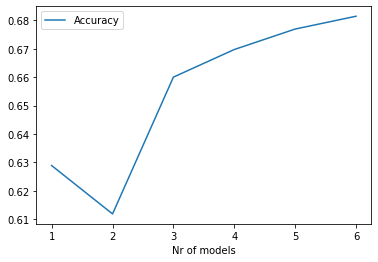

In [44]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [45]:
print("Accuracy: " + str(predict(models, x_test, y_testc)))

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

Accuracy: 0.6837


## Correlation between models

In [46]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


In [47]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 6/6 [00:00<00:00, 105.24it/s]


In [48]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
display(correlation_matrix_df)
correlation_matrix_df.to_csv(PATH + MODEL_NAME + "_correlation_matrix.csv")
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3,4,5
0,NaN,0.456018,0.452337,0.444810,0.439115,0.423720
1,0.456018,NaN,0.426482,0.430576,0.457107,0.400398
2,0.452337,0.426482,NaN,0.466459,0.423453,0.437327
3,0.444810,0.430576,0.466459,NaN,0.427926,0.460736
4,0.439115,0.457107,0.423453,0.427926,NaN,0.361265
5,0.423720,0.400398,0.437327,0.460736,0.361265,NaN


Average correlation: 0.43384857070062377
